# Imitation learning training script!!!!

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
import pathlib

import random
import time

import matplotlib.pyplot as plt

import cv2

## Check if CUDA is available

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Data loader

In [3]:
max_x = 2.5
max_z = 5.0

In [4]:
def load_data_session(session_path):
    
    res = []
    
    session_path = pathlib.Path(session_path)
    labels_path = session_path / "labels.csv"
    
    labels_df = pd.read_csv(labels_path, header=None ,skiprows=1)
    
    for index, row in labels_df.iterrows():
        
        img_path = session_path / row[0]
        img = cv2.imread(str(img_path))
        
        if img is None:
            print("cannot load image:", img_path)
        
        res.append((img / 255, row[1] / max_x, row[2] / max_z))
        
    npres = np.array(res, dtype=object)
    np.random.shuffle(npres)
    
    return npres

In [5]:
res = load_data_session("/home/kazuh/Documents/UBC/ENPH_353/training_data/all_sessions/session_20251126_173028_839imgs")
print(res[0])

[array([[[0.74509804, 0.51372549, 0.45098039],
         [0.76862745, 0.5372549 , 0.4745098 ],
         [0.75686275, 0.5254902 , 0.4627451 ],
         ...,
         [0.78823529, 0.55686275, 0.49411765],
         [0.80784314, 0.57647059, 0.51372549],
         [0.78823529, 0.55686275, 0.49411765]],

        [[0.76078431, 0.52941176, 0.46666667],
         [0.77254902, 0.54117647, 0.47843137],
         [0.76078431, 0.52941176, 0.46666667],
         ...,
         [0.80784314, 0.57647059, 0.51372549],
         [0.78823529, 0.55686275, 0.49411765],
         [0.79607843, 0.56470588, 0.50196078]],

        [[0.76862745, 0.5372549 , 0.4745098 ],
         [0.76470588, 0.53333333, 0.47058824],
         [0.75686275, 0.5254902 , 0.4627451 ],
         ...,
         [0.79215686, 0.56078431, 0.49803922],
         [0.78431373, 0.55294118, 0.49019608],
         [0.79215686, 0.56078431, 0.49803922]],

        ...,

        [[0.29019608, 0.62745098, 0.60392157],
         [0.28235294, 0.61960784, 0.59607843]

In [6]:
def load_all_sessions(base_path):
    all_data = []
    
    base_path = pathlib.Path(base_path)
    
    for session_dir in base_path.iterdir():
        if session_dir.is_dir():
            session_data = load_data_session(session_dir)
            all_data.append(session_data)
    
    all_data_np = np.concatenate(all_data, axis=0)
    np.random.shuffle(all_data_np)
    
    return all_data_np

In [7]:
class JackSessionDataset(torch.utils.data.Dataset):
    
    def __init__(self, session_path):
        session_path = pathlib.Path(session_path)
        labels_path = session_path / "labels.csv"

        df = pd.read_csv(labels_path, header=None, skiprows=1)
        self.img_paths = [session_path / row[0] for _, row in df.iterrows()]
        self.x_vals = df[1].values / max_x
        self.z_vals = df[2].values / max_z

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(str(self.img_paths[idx]))

        if img is None:
            raise RuntimeError(f"Could not load {self.img_paths[idx]}")

        img = img.astype(np.float32) / 255.0
        img = torch.tensor(img).permute(2, 0, 1)  # HWC → CHW
        
        label = torch.tensor([self.x_vals[idx], self.z_vals[idx]], dtype=torch.float32)
        return img, label

## Design Model

In [8]:
class JackDrivingModel(nn.Module):

    def __init__(self, img_channels = 3, img_h = 600, img_w = 800, act_dim = 2):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(img_channels, 24, kernel_size=5, stride=2), nn.ReLU(),
            nn.Conv2d(24, 36, kernel_size=5, stride=2), nn.ReLU(),
            nn.Conv2d(36, 48, kernel_size=5, stride=2), nn.ReLU(),
            nn.Conv2d(48, 64, kernel_size=3, stride=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU()
        )

        with torch.no_grad():
            dummy = torch.zeros(1, img_channels, img_h, img_w)
            conv_out = self.conv(dummy)
            conv_feat_dim = conv_out.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(conv_feat_dim, 100), nn.ReLU(),
            nn.Linear(100, 50), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(50, act_dim)  # [vx, wz]
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

        

In [9]:
def reset_model_weights(model):
    """
    Reinitializes all model parameters by calling reset_parameters()
    for each layer that implements it (Conv, Linear, etc.).
    """
    for layer in model.modules():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()


## Training

In [10]:
model = JackDrivingModel(img_channels=3, img_h=600, img_w=800, act_dim=2)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [11]:
def train_one_session(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [12]:
base_path = pathlib.Path("/home/kazuh/Documents/UBC/ENPH_353/training_data/all_sessions")
session_dirs = sorted([d for d in base_path.iterdir() if d.is_dir()])



=== Epoch 1/2 ===
Epoch 1 completed in 57.25 seconds. Average Loss: 0.0434


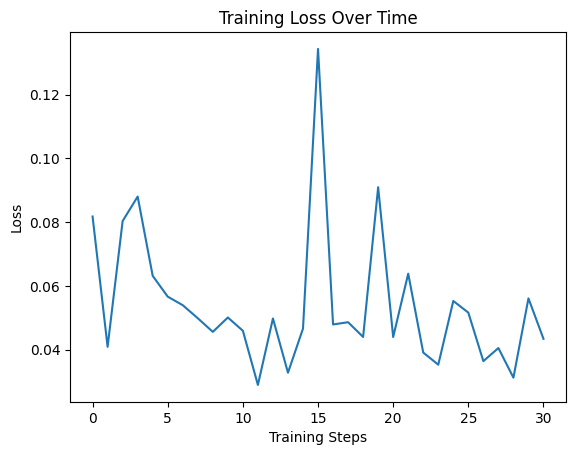


=== Epoch 2/2 ===
Epoch 2 completed in 56.82 seconds. Average Loss: 0.0427


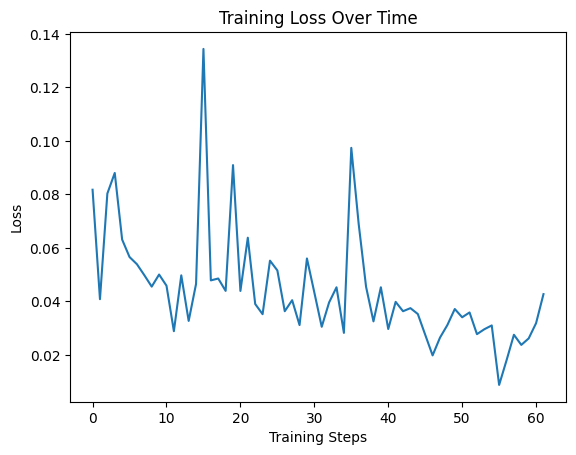

In [ ]:
batch_size = 32
num_epochs = 2

loss_history = []

for epoch in range(num_epochs):
    time1 = time.time()
    print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")
    
    random.shuffle(session_dirs)
    
    for session in session_dirs:

        dataset = JackSessionDataset(session)
        loader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=True,
                                             num_workers=8)

        avg_loss = train_one_session(model, loader, optimizer, criterion, device)
        loss_history.append(avg_loss)
        
    time2 = time.time()
    print(f"Epoch {epoch+1} completed in {time2 - time1:.2f} seconds. Average Loss: {avg_loss:.4f}")

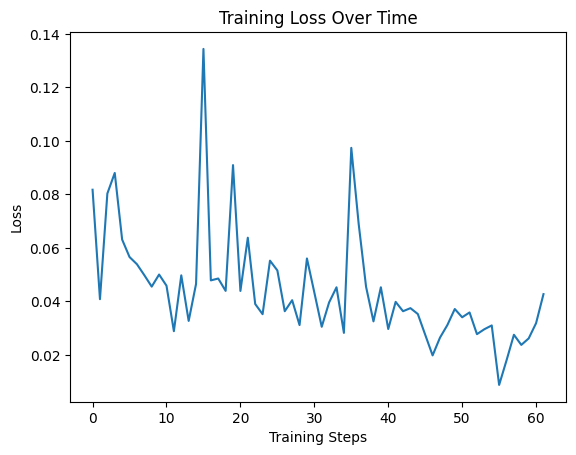

In [14]:
plt.plot(loss_history)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()